In [1]:
# Statement
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import pandas as pd
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame> combined estimated coefficient and standard error of model estimate
    """
    df = pd.DataFrame({"coef": results.params, "std err": results.bse})
    return df

In [3]:
# 1. Prepare Data
df_salary = pd.read_csv("salary_data.csv")
df_salary.rename(columns = {'Education Level':'EducationLevel', 'Years of Experience':'YearsOfExperience'}, inplace=True)
df_salary

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


In [4]:
# Check Missing Value
df_salary.isna().sum()

Age                  2
Gender               2
EducationLevel       2
Job Title            2
YearsOfExperience    2
Salary               2
dtype: int64

In [5]:
# Clean Missing Value
df_salary = df_salary.dropna()

In [6]:
df_salary.isna().sum()

Age                  0
Gender               0
EducationLevel       0
Job Title            0
YearsOfExperience    0
Salary               0
dtype: int64

In [7]:
# Check Duplicated Data
df_salary.duplicated().sum()

49

In [8]:
df_salary[df_salary.duplicated(keep=False)]

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
140,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
209,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
210,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
211,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
...,...,...,...,...,...,...
369,33.0,Male,Bachelor's,Junior Business Analyst,4.0,60000.0
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


In [9]:
# Clean Duplicate Data
df_salary = df_salary.drop_duplicates(keep="first")
df_salary.duplicated().sum()

0

In [10]:
df_salary

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
348,28.0,Female,Bachelor's,Junior Operations Manager,1.0,35000.0
349,36.0,Male,Bachelor's,Senior Business Development Manager,8.0,110000.0
350,44.0,Female,PhD,Senior Data Scientist,16.0,160000.0
351,31.0,Male,Bachelor's,Junior Marketing Coordinator,3.0,55000.0


In [11]:
# 2. Data Description
df_salary.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,324.0,37.382716,7.185844,23.0,31.0,36.5,44.0,53.0
YearsOfExperience,324.0,10.058642,6.650470,0.0,4.0,9.0,16.0,25.0
Salary,324.0,99985.648148,48652.271440,350.0,55000.0,95000.0,140000.0,250000.0


In [12]:
df_salary["Gender"].value_counts()

Male      170
Female    154
Name: Gender, dtype: int64

In [13]:
df_salary["EducationLevel"].value_counts()

Bachelor's    191
Master's       91
PhD            42
Name: EducationLevel, dtype: int64

In [14]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 371
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                324 non-null    float64
 1   Gender             324 non-null    object 
 2   EducationLevel     324 non-null    object 
 3   Job Title          324 non-null    object 
 4   YearsOfExperience  324 non-null    float64
 5   Salary             324 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [15]:
# Correlation Number Variable
df_salary[["Age","YearsOfExperience", "Salary"]].corr()

,Age,YearsOfExperience,Salary
Age,1.000000,0.979192,0.916543
YearsOfExperience,0.979192,1.000000,0.924455
Salary,0.916543,0.924455,1.000000


In [16]:
# Average Salary

In [17]:
# Salary by Gender
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

In [18]:
# Salary by Education Level
df_salary.groupby("EducationLevel")["Salary"].mean()

EducationLevel
Bachelor's     73902.356021
Master's      127912.087912
PhD           158095.238095
Name: Salary, dtype: float64

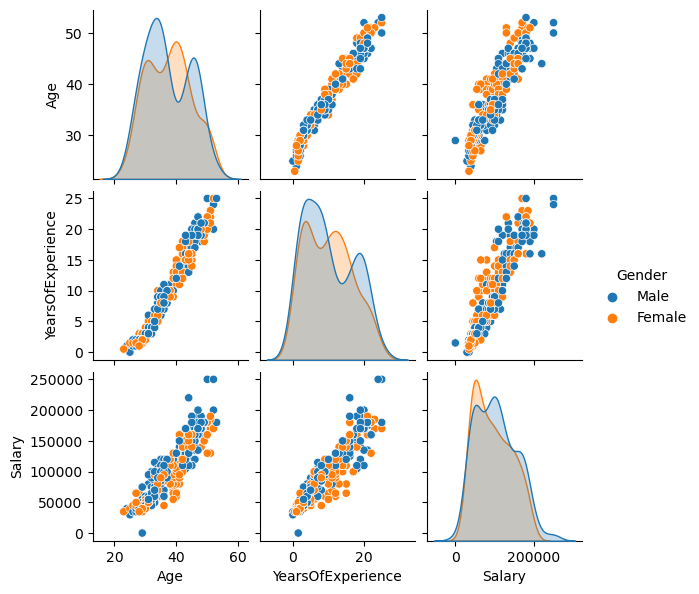

In [19]:
# Plot
sns.pairplot(data=df_salary, hue="Gender", height=2)

In [20]:
#3. Statistic Test
# H0:Rata-rata Salary Male sama dengan dari rata-rata Salary Female
# H1:Rata-rata Salary Male lebih besar dari rata-rata Salary Female
significance_level = 0.10
#Semakin bertambahnya Year of Experiencce seseorang, maka Salary yang diterimanya juga meningkat.
#Semakin besar Age, maka semakin banyak Year of Experience yang dapat diakumulasikan.
#Salary tidak dipengaruhi oleh Gender.

In [21]:
# Pre-Analysis
# Menghitung jumlah data Male dan Female
significance_level = 0.10
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

In [22]:
# Analysis
# Gaji Male
df_male = df_salary[df_salary["Gender"]=="Male"]["Salary"].values
# Gaji Female
df_female = df_salary[df_salary["Gender"]=="Female"]["Salary"].values
# Variansi
np.var(df_male), np.var(df_female)

(2571353207.6989617, 2097896989.374262)

In [23]:
from scipy import stats
result = stats.ttest_ind(a = df_male, b = df_female, equal_var=False, alternative = "greater")
result.pvalue

0.08675461782037655

In [25]:
if result.pvalue < significance_level:
    print("Tolak H0")
else:
    print("Gagal menolak H0")

Tolak H0


In [26]:
# Degree of Freedom
df_data = len(df_male)+len(df_female)
df_data

324

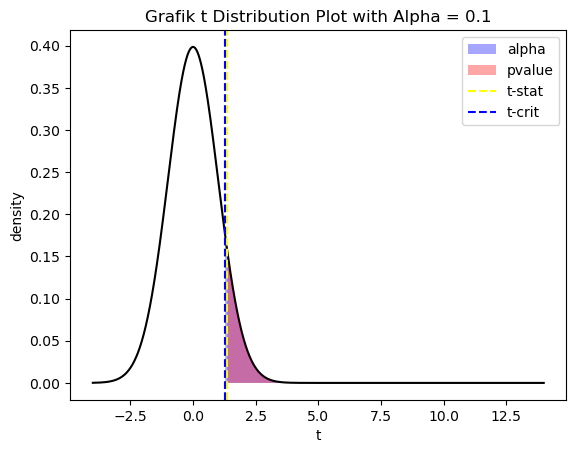

In [27]:
# Plot
x = np.arange(-4, 14, 0.001)
plt.plot(x, stats.t.pdf(x, df = df_data), color='black')
x_alpha = np.arange(stats.t.ppf(1-significance_level, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, y1 = y_alpha, facecolor = 'blue', alpha = 0.35, label = 'alpha')

# Plot Value
x_pvalue = np.arange(result.statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df = df_data)
plt.fill_between(x = x_pvalue, y1 = y_pvalue, facecolor = 'red', alpha = 0.35, label = 'pvalue')
plt.axvline(np.round(result.statistic, 4), color ="yellow", linestyle = "--", label ="t-stat")
t_crit = np.round(stats.t.ppf(1-significance_level, df = df_data), 4)
plt.axvline(t_crit, color ="blue", linestyle = "--", label ="t-crit")
plt.legend()
plt.xlabel("t")
plt.ylabel("density")
plt.title(f'Grafik t Distribution Plot with Alpha = {significance_level}');
plt.show()

In [28]:
# Confidence Level
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
cm = CompareMeans(d1 = DescrStatsW(data=df_male), 
                  d2 = DescrStatsW(data=df_female))
lower, upper = cm.tconfint_diff(alpha=significance_level, alternative='two-sided', usevar='unequal')
print("Confidence Interval adalah :", "[", lower, upper, "]")

Confidence Interval adalah : [ -1535.8717753119818 16208.438620231766 ]


In [29]:
# 4. Regression Model
# Hapus Kolom Job Title karena tidak relevan dengan tujuan
df_salary.drop("Job Title", axis=1, inplace=True)
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


In [30]:
# Transform Categorical Data to Numerik
df_salary["EducationLevel"].value_counts()

Bachelor's    191
Master's       91
PhD            42
Name: EducationLevel, dtype: int64

In [31]:
# Check Gender
df_salary["Gender"].value_counts()

Male      170
Female    154
Name: Gender, dtype: int64

In [32]:
# Transform Data
# Gender Male = 0, Female = 1
# Education Level Bachelor's = 0, Master's = 1, PhD = 2
df_salary["EducationLevel"] = df_salary["EducationLevel"].map({"Bachelor's":0,"Master's":1,"PhD":2})
df_salary["Gender"] = df_salary["Gender"].map({"Male":0,"Female":1})
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0


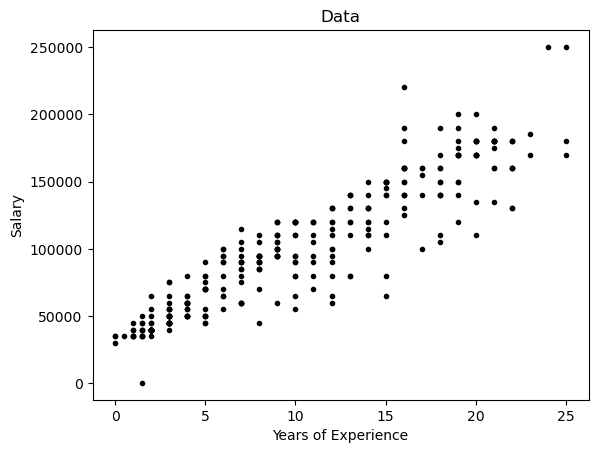

In [33]:
# Single Predictor Modelling
x = df_salary["YearsOfExperience"]
y = df_salary["Salary"]
plt.scatter(x, y, color = "k", marker=".")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Data")
plt.show()

In [34]:
# Fit Linear Regression Using Horsepower Variable
# Create OLS model
model = smf.ols("Salary ~ YearsOfExperience", df_salary)
results_model_salary = model.fit()
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,31959.508721,1873.552736
YearsOfExperience,6762.954641,155.446221


In [35]:
results_model_salary.rsquared
# Salary = 31960 + 6763 × Years of Experience

0.8546166681460778

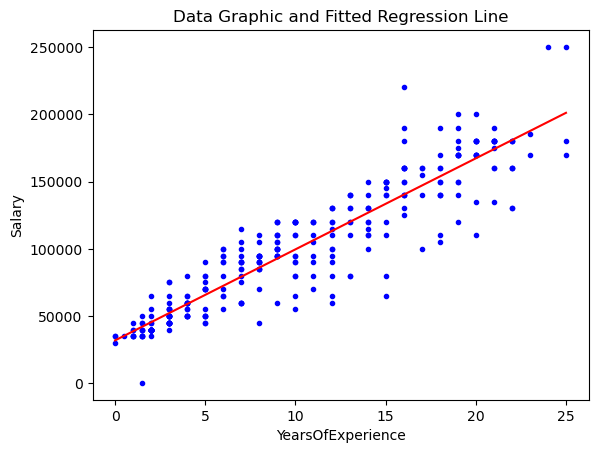

In [36]:
# Visualization
predictor = "YearsOfExperience"
outcome = "Salary"
data = df_salary.copy()
results_ = results_salary.copy()
plt.scatter(data[predictor], data[outcome], color = "b", marker=".")

# Calculate the Fitted Values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]
x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)
fitted_values = a_hat + b_hat * x_domain

# Show the Plot
plt.plot(x_domain, fitted_values, label="Fitted line", color = "r")
plt.ylabel(outcome)
plt.xlabel(predictor)
plt.title("Data Graphic and Fitted Regression Line")
plt.show()

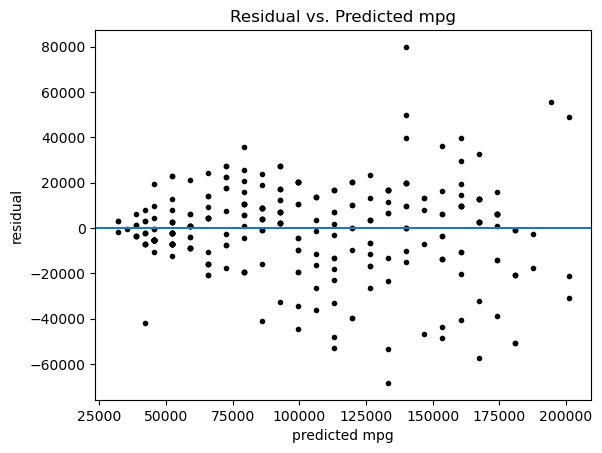

In [37]:
# Residual Plot
plt.scatter(results_model_salary.fittedvalues, results_model_salary.resid, marker=".", c = "k")
plt.axhline([0])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residual vs. Predicted mpg")
plt.show()

In [38]:
results_model_salary.rsquared

0.8546166681460778

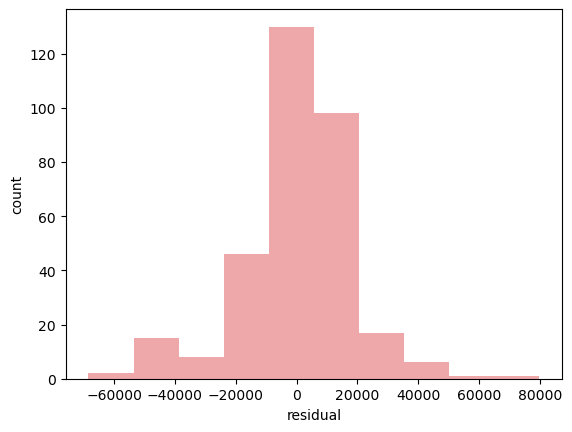

In [39]:
# Normality of Error Assumption
plt.hist(results_model_salary.resid, color='tab:red', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")
plt.show()

In [40]:
# Fit Linear Regression with Log Transform on Weight Variable
df_salary["logYOE"] = np.log(df_salary["YearsOfExperience"])
df_salary.loc[df_salary["YearsOfExperience"] == 0, "logYOE"] = 0
df_salary.describe().transpose()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,count,mean,std,min,25%,50%,75%,max
Age,324.0,37.382716,7.185844,23.000000,31.000000,36.500000,44.000000,53.000000
Gender,324.0,0.475309,0.500162,0.000000,0.000000,0.000000,1.000000,1.000000
EducationLevel,324.0,0.540123,0.713597,0.000000,0.000000,0.000000,1.000000,2.000000
YearsOfExperience,324.0,10.058642,6.650470,0.000000,4.000000,9.000000,16.000000,25.000000
Salary,324.0,99985.648148,48652.271440,350.000000,55000.000000,95000.000000,140000.000000,250000.000000
logYOE,324.0,2.005576,0.874208,-0.693147,1.386294,2.197225,2.772589,3.218876


In [41]:
# Create OLS
model = smf.ols("Salary ~ logYOE", df_salary)
results_logtransform = model.fit()
results_salary_log = print_coef_std_err(results_logtransform)
results_logtransform.rsquared

0.7656239539695425

In [42]:
# Multiple Predictors Modelling
df_salary.drop("logYOE", axis=1, inplace=True)
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0


In [43]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, shuffle = True, random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

In [44]:
# Evaluate Model using K-fold Cross Validation
# Create Class Model
ols_all_pred = StatsmodelsRegressor(
    smf.ols, "Salary ~ Age + Gender + C(EducationLevel) + YearsOfExperience + Age:YearsOfExperience")

# Create K-fold Splitter Object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)
scores_ols_all_pred = cross_val_score(
    estimator = ols_all_pred, X = df_salary, y = df_salary["Salary"], cv = kfold,scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.892141,Folds 1
1,0.902729,Folds 2
2,0.912515,Folds 3
3,0.825113,Folds 4
4,0.897267,Folds 5


In [45]:
scores_ols_all_pred["test_rsquared"].mean()

0.8859529642576718

In [46]:
# Fit Linear Regression Using All Predictors
# Create OLS model
model = smf.ols("Salary ~ Age + Gender + C(EducationLevel) + YearsOfExperience + Age:YearsOfExperience", df_salary)
results_model_salary = model.fit()
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,-44159.185552,16580.736611
C(EducationLevel)[T.1],19574.074815,2257.344892
C(EducationLevel)[T.2],26339.473807,3160.610738
Age,3042.039143,611.919060
Gender,-9310.571777,1766.475849
YearsOfExperience,2433.641886,1211.995905
Age:YearsOfExperience,3.452762,21.044653


In [47]:
# Centering Predictor Age
mean_age = df_salary["Age"].mean()
mean_age = np.round(mean_age,0)
mean_age

df_salary["Age"] = df_salary["Age"]-mean_age
df_salary.rename(columns = {"Age":"AgeCentered"}, inplace=True)
df_salary.head()

,AgeCentered,Gender,EducationLevel,YearsOfExperience,Salary
0,-5.0,0,0,5.0,90000.0
1,-9.0,1,1,3.0,65000.0
2,8.0,0,2,15.0,150000.0
3,-1.0,1,0,7.0,60000.0
4,15.0,0,1,20.0,200000.0


In [48]:
# Create Class Model
ols_all_pred = StatsmodelsRegressor(
    smf.ols, "Salary ~ AgeCentered + Gender + C(EducationLevel) + YearsOfExperience + AgeCentered:YearsOfExperience")

# Create K-fold Splitter
kfold = KFold(n_splits=5, shuffle = True, random_state=12)
scores_ols_all_pred = cross_val_score(
    estimator = ols_all_pred, X = df_salary, y = df_salary["Salary"], cv = kfold, scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.849681,Folds 1
1,0.907836,Folds 2
2,0.873470,Folds 3
3,0.938117,Folds 4
4,0.881399,Folds 5


In [49]:
scores_ols_all_pred["test_rsquared"].mean()
# Model yang digunakan semua media memiliki kecocokan yang baik
# Dapat menjelaskan 89% varians gaji.

0.8901007028969221

In [50]:
# Create OLS model
model = smf.ols(
    'Salary ~ AgeCentered + Gender + C(EducationLevel) + YearsOfExperience + AgeCentered:YearsOfExperience', df_salary)
results = model.fit()
results_salary = print_coef_std_err(results)
results_salary

,coef,std err
Intercept,68396.262743,6722.803498
C(EducationLevel)[T.1],19574.074815,2257.344892
C(EducationLevel)[T.2],26339.473807,3160.610738
AgeCentered,3042.039143,611.919060
Gender,-9310.571777,1766.475849
YearsOfExperience,2561.394070,714.405923
AgeCentered:YearsOfExperience,3.452762,21.044653


In [51]:
# Gaji Bachelor = 68396+3042 ×(Age - 37)−9311×Gender+2561×YearsOfExperience+3×(Age - 37)×YearsOfExperience
# Gaji Master = 68396+19574+3042×(Age - 37)−9311×Gender+2561×YearsOfExperience+3×(Age - 37)×YearsOfExperience
# Gaji PhD = 68396+26339+3042×(Age - 37)−9311×Gender+2561×YearsOfExperience+3×(Age - 37)×YearsOfExperience

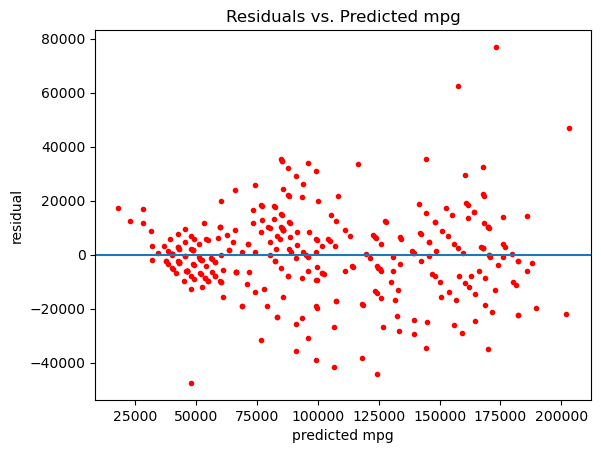

In [53]:
# Residual Plot and Explained Variance
plt.scatter(results.fittedvalues, results.resid, marker=".", c = "r")
plt.axhline([0])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")
plt.show()

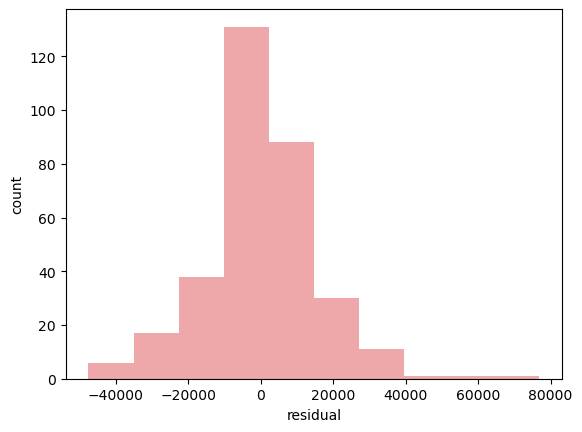

In [54]:
# Normality of Error Assumption
plt.hist(results.resid, color='tab:red', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")
plt.show()